In [1]:
!pip install stop-words

from stop_words import get_stop_words # Para hacer la eliminacion de stopword
import unicodedata # esta libreria la utlilizo para transformar caracteres en formas basicas
from collections import Counter # Libreria para realizar el conteo de las palabras
from wordcloud import WordCloud # Libreria para hacer el worldCloud del vocabulario
import matplotlib.pyplot as plt # Libreria para hacer las graficas que necesito
import re # Para manipulacion de texto en el preprocesado
import pandas as pd # para trabajar con df
from nltk.stem.porter import * # para lematizar
import nltk
nltk.download('wordnet')

  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=9da83ab4695431767e612abd4ddf49e90ada4be877def89fb060e489d7215c3a
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop-words


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
# Hago una funcion para hayar el wordcloud del corpus de las valoraciones 0 y 1 . Para ver que vocavulario tiene cada sentimiento

def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()



# Hago la funcion de preprocesamiento del corpus

def preprocess(text):
    #obtengo stop words
    sw_list = get_stop_words('en')

    # Defino la funcion para normalizar el corpus y para quedarnos con los caracteres alfabeticos
    def text_normalize(text):
        normalize_text = []
        for sentence in text:
            if not sentence != sentence:
              sentence = unicodedata.normalize('NFKD', sentence).lower().encode('ascii', errors='ignore').decode('utf-8')
              sentence = re.sub(' +', ' ', ' '.join([word if word.isalpha() else '' for word in sentence.split()])).strip()
              normalize_text.append(sentence)
            else:
              normalize_text.append('None')

        return normalize_text


    # Defino la funcion para eliminar las stop words
    def remove_stopwords(normalize_text):
        preprocessed_texts = []
        for sentence in normalize_text:
            sentence = ' '.join([word for word in sentence.split() if word not in sw_list])
            preprocessed_texts.append(sentence)
        return preprocessed_texts



    # Ejecuto las funciones
    normalized_texts = text_normalize(text)
    preprocessed_texts = remove_stopwords(normalized_texts)

    return preprocessed_texts

# Funcion para tranformar overall en valoracion positiva o negativa
def transformar_overall(valor):
    if valor <= 2.0:
        return 0
    else:
        return 1

def crear_df_balanceado(df):
    # Dividir el DataFrame en dos subconjuntos basados en el valor de la columna 'overall'
    df_0 = df[df['overall'] == 0]
    df_1 = df[df['overall'] == 1]

    print("Número de registros 'overall' = 0:", len(df_0))
    print("Número de registros 'overall' = 1:", len(df_1))

    # Seleccionar aleatoriamente 2500 registros de cada subconjunto
    df_0_balanced = df_0.sample(n=3500, replace=True)
    df_1_balanced = df_1.sample(n=3500, replace=True)

    # Concatenar los subconjuntos seleccionados
    df_balanced = pd.concat([df_0_balanced, df_1_balanced])

    return df_balanced


In [3]:
# Accedo al dataset guardado en drive

from google.colab import drive
drive.mount('/content/drive')

data_lenguage = pd.read_csv("/content/drive/MyDrive/data_lenguage.csv", sep=';')
data_lenguage.shape

# Limito el dataset a 20000 registros porque la cpu no me permite muchos mas registros

lenguage_limited = data_lenguage.iloc[:30000]
lenguage_limited.shape

Mounted at /content/drive


<ipython-input-3-620be477311b>:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data_lenguage = pd.read_csv("/content/drive/MyDrive/data_lenguage.csv", sep=';')


(30000, 12)

In [4]:
lenguage_limited[:10]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,1.0,True,"06 9, 2014",A21ROB4YDOZA5P,0439381673,Mary M. Clark,I used to play this game years ago and loved i...,Did not like this,1402272000,NaN,NaN,NaN
1,3.0,True,"05 10, 2014",A3TNZ2Q5E7HTHD,0439381673,Sarabatya,The game itself worked great but the story lin...,Almost Perfect,1399680000,NaN,NaN,NaN
2,4.0,True,"02 7, 2014",A1OKRM3QFEATQO,0439381673,Amazon Customer,I had to learn the hard way after ordering thi...,DOES NOT WORK WITH MAC OS unless it is 10.3 or...,1391731200,15,NaN,NaN
3,1.0,True,"02 7, 2014",A2XO1JFCNEYV3T,0439381673,ColoradoPartyof5,The product description should state this clea...,does not work on Mac OSX,1391731200,11,NaN,NaN
4,4.0,True,"01 16, 2014",A19WLPIRHD15TH,0439381673,Karen Robinson,I would recommend this learning game for anyon...,Roughing it,1389830400,NaN,NaN,NaN
5,5.0,True,"01 7, 2014",A1TLA7XXSZMTS7,0439381673,lori smith,Choose your career which sets your money for t...,Love this game! Fun and educational.,1389052800,2,NaN,NaN
6,3.0,True,"10 22, 2013",A3I9GK5OO42B0I,0439381673,Edwin Grabill,Would like it more if they had at least update...,Would like it more if they had at least update...,1382400000,2,NaN,NaN
7,5.0,False,"10 21, 2013",A3TPP95Y9DH3L9,0439381673,MollyMoore,It took a few hours to get this up and running...,Off to a rough start but once it got going the...,1382313600,NaN,NaN,NaN
8,5.0,True,"10 29, 2012",A19GOZTT15KPG1,0439381673,Dovie,I oredered this for a daughter who is now 33 a...,The Oregon Trail--5th Edition,1351468800,3,NaN,NaN
9,5.0,False,"02 8, 2010",A1441WFJ5KRP7J,0439381673,Zoe,Well I thought since this idem didn't have any...,Great game but why do the rattle snakes love me?,1265587200,NaN,NaN,NaN


In [5]:
# Elimino los registros nan


print(lenguage_limited.shape)
lenguage_limited = lenguage_limited.dropna(subset=['overall', 'reviewText'])
lenguage_limited.reset_index(drop=True, inplace=True)
print(lenguage_limited.shape)


(30000, 12)
(29992, 12)


In [6]:
# Compruebo que no hay registros nan

print(lenguage_limited['overall'].isna().sum())
print(lenguage_limited['reviewText'].isna().sum())


0
0


In [7]:
lenguage_limited['overall'] = lenguage_limited['overall'].apply(transformar_overall)

In [8]:
# Compruebo que preprocess funciona

preprocess_text = preprocess(lenguage_limited['reviewText'])
print(len(preprocess_text))
print(lenguage_limited['reviewText'][:3])
print(preprocess_text[:3])

29992
0    I used to play this game years ago and loved i...
1    The game itself worked great but the story lin...
2    I had to learn the hard way after ordering thi...
Name: reviewText, dtype: object
['used play game years ago loved found work computer even though said work windows', 'game worked great story line videos never sound fine picture freeze go black every', 'learn hard way ordering macbook pro work unless mac os version found contact learning company prompt also laptop microsoft program loaded beautifully microsoft microsoft purchase enjoy mac systems will likely']


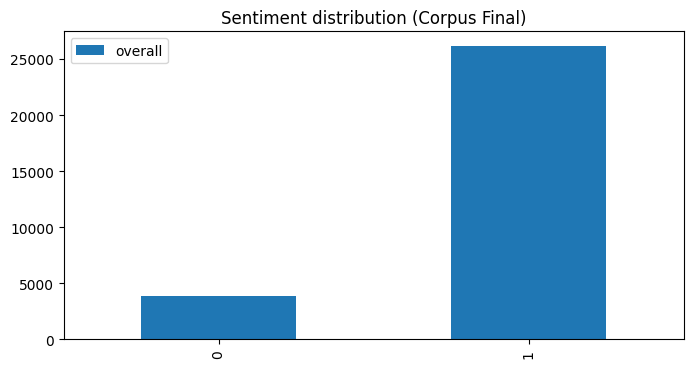

In [9]:
# Hago una grafica para saber como de balanceado el df

aux_df = pd.DataFrame(lenguage_limited['overall'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

In [11]:
# Aplico la funcion para limpiar el corpus


lenguage_limited['reviewText'] = preprocess(lenguage_limited['reviewText'])


In [12]:
# Hago otra vez un borrado de los nan por si se ha creado alguno al precesar el texto

lenguage_limited = lenguage_limited.dropna(subset=['overall', 'reviewText'])

In [13]:
lenguage_limited['reviewText']

0        used play game years ago loved found work comp...
1        game worked great story line videos never soun...
2        learn hard way ordering macbook pro work unles...
3        product description state product description ...
4        recommend learning game anyone likes learning ...
                               ...                        
29987    works perfectly great never notified shipping ...
29988                                            love love
29989                                       best game time
29990    another one several games son still enjoy now ...
29991    game came good condition worked game controls ...
Name: reviewText, Length: 29992, dtype: object

In [14]:
# Miro cuantos registros overall = 0 hay en df
print((lenguage_limited['overall'] == 0).sum())

3836


In [15]:
print(lenguage_limited['overall'].isna().sum())
print(lenguage_limited['reviewText'].isna().sum())

0
0


In [16]:
#aplico la funcion para balancear el df

lenguage_limited_balanced = crear_df_balanceado(lenguage_limited)


# Vuelvo a limpiar los nan por si con la funcion preprocess se ha creado algun nan
lenguage_limited_balanced = lenguage_limited_balanced.dropna(subset=['overall', 'reviewText'])
print(lenguage_limited_balanced.shape)

Número de registros 'overall' = 0: 3836
Número de registros 'overall' = 1: 26156
(7000, 12)


In [17]:
print(lenguage_limited_balanced['overall'].isna().sum())
print(lenguage_limited_balanced['reviewText'].isna().sum())

0
0


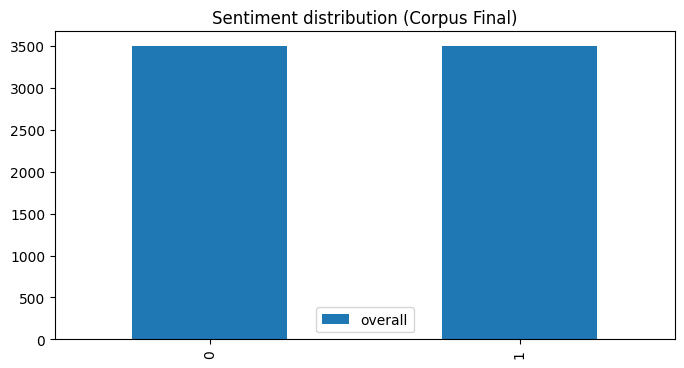

In [18]:
# miro si esta balanceado despues de aplicar las funcion overall y el balanceado del data set

aux_df = pd.DataFrame(lenguage_limited_balanced['overall'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

In [19]:
# Creo un csv del dataframe preprocesado y lo guardo en google drive para poder acceder a el
lenguage_limited_balanced.to_csv('lenguage_limited_balanced.csv', sep=';', index=False)

from google.colab import drive
drive.mount('/content/drive')

!cp lenguage_limited_balanced.csv /content/drive/MyDrive/lenguage_limited_balanced.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
lenguage_limited_balanced[:10]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
24282,0,True,"03 1, 2016",A158CGQ9Q49FBO,B00002DHEV,Sully,receive item today find broken top area near m...,Broken Merchandise,1456790400,NaN,NaN,NaN
10831,0,True,"04 5, 2017",A2N0QLZXJG1GUR,B00000JRSB,Amazon Customer,paid extra said booklet book,Really,1491350400,NaN,{'Format:': ' Video Game'},NaN
19127,0,True,"11 20, 2009",A86IZI0UBBCPB,B00001X5C3,Vernon Johnson,wasnt even right game ordered wrestlemania sen...,This Sucks,1258675200,NaN,NaN,NaN
2520,0,False,"08 29, 2001",A1HJ2ADX8TH5F6,B000006RGS,G. Hollis,going fly face convention wisdom assert tomb r...,"Concept is good, but tedious game play really ...",999043200,7,{'Format:': ' Video Game'},NaN
26888,0,True,"08 3, 2015",A17T0HYR6AZEJ1,B00002ST37,Ryan Guerrette,gameboy pocket got yellow gameboy color instead,One Star,1438560000,NaN,{'Color:': ' Yellow'},NaN
24615,0,True,"01 13, 2015",A1Y3SN6JR3ULDU,B00002DHEV,Casey,thought items got paid,meh.,1421107200,NaN,NaN,NaN
84,0,True,"02 15, 2013",AFVETWC6I3BLJ,0700026657,Jens Dietz,much work set play requires internet play many...,not the same as 1701,1360886400,12,NaN,NaN
2072,0,True,"05 14, 2017",A139X1M9SMGATJ,9882106463,sunsetbayus,right cord game,One Star,1494720000,NaN,NaN,NaN
5997,0,False,"01 17, 2001",A2396ASCFP9L7F,B00000I1BB,Amazon Customer,gave game stars south park possible might enjo...,Worst game I've ever played...,979689600,4,NaN,NaN
26411,0,False,"01 4, 2000",A3AJ6W65FMMVDU,B00002S6CC,Zachariah,must say ok liked tv show must great tv let po...,Good but... NOT!,946944000,10,{'Format:': ' Video Game'},NaN
